import /content/drive/MyDrive/v2x_data/veremi_stratified_200000.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)




Mounted at /content/drive


In [2]:
from datetime import datetime

# Get current date and time
now = datetime.now()

# Print formatted datetime
print("Current date and time:", now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time: 2025-06-15 15:36:43


In [3]:
import zipfile
zip_path = '/content/drive/MyDrive/v2x_data/veremi_stratified_200000.zip'
extract_dir = '/content/veremi_subsets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Unzipped to:", extract_dir)


Unzipped to: /content/veremi_subsets


In [4]:
import pandas as pd

df_balanced = pd.read_csv('/content/veremi_subsets/veremi_stratified_200000.csv')
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   type          200000 non-null  int64  
 1   sendTime      200000 non-null  float64
 2   sender        200000 non-null  int64  
 3   senderPseudo  200000 non-null  int64  
 4   messageID     200000 non-null  int64  
 5   class         200000 non-null  int64  
 6   posx          200000 non-null  float64
 7   posy          200000 non-null  float64
 8   posz          200000 non-null  float64
 9   spdx          200000 non-null  float64
 10  spdy          200000 non-null  float64
 11  spdz          200000 non-null  float64
 12  aclx          200000 non-null  float64
 13  acly          200000 non-null  float64
 14  aclz          200000 non-null  float64
 15  hedx          200000 non-null  float64
 16  hedy          200000 non-null  float64
 17  hedz          200000 non-null  float64
 18  Atta

In [5]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd

# Define subset sizes
subset_sizes = [20000, 40000, 80000, 120000, 160000, 200000]

# Split normal and attack records
df_normal = df_balanced[df_balanced['binary_label'] == 0]
df_attack = df_balanced[df_balanced['binary_label'] == 1]
attack_class_proportions = df_attack['class'].value_counts(normalize=True)

# Initialize tracking DataFrame
subset_class_summary = pd.DataFrame()

for size in subset_sizes:
    n_attack = size // 2
    n_normal = size // 2

    # Stratified attack sampling
    attack_samples = []
    for cls, frac in attack_class_proportions.items():
        cls_pool = df_attack[df_attack['class'] == cls]
        n_cls = min(len(cls_pool), int(n_attack * frac))
        attack_samples.append(cls_pool.sample(n=n_cls, random_state=42))
    attack_subset = pd.concat(attack_samples)

    # Pad with extra if needed
    if len(attack_subset) < n_attack:
        remaining = n_attack - len(attack_subset)
        extra = df_attack.drop(attack_subset.index).sample(n=remaining, random_state=42)
        attack_subset = pd.concat([attack_subset, extra])

    # Normal class sampling
    normal_subset = df_normal.sample(n=n_normal, random_state=42)

    # Combine and shuffle
    df_subset = shuffle(pd.concat([attack_subset, normal_subset]), random_state=42).reset_index(drop=True)

    # Save to file
    df_subset.to_csv(f'veremi_stratified_{size}.csv', index=False)
    print(f"\n Saved veremi_stratified_{size}.csv with {len(df_subset)} records")
    print(df_subset["binary_label"].value_counts())
    # ---- Plot distributions ----
    binary_counts = df_subset['binary_label'].value_counts(normalize=True) * 100
    class_counts = df_subset['class'].value_counts(normalize=True).sort_index() * 100
    # ---- Track class distribution for summary ----
    class_row = class_counts.copy()
    class_row['subset_size'] = size
    subset_class_summary = pd.concat([subset_class_summary, class_row.to_frame().T], ignore_index=True)
    print("------------")

# ---- Final formatting ----
subset_class_summary = subset_class_summary.set_index('subset_size')
subset_class_summary.index.name = 'Sample Size'
subset_class_summary = subset_class_summary[sorted(subset_class_summary.columns, key=lambda x: int(x))]
subset_class_summary = subset_class_summary.fillna(0)
subset_class_summary.head(10)


 Saved veremi_stratified_20000.csv with 20000 records
binary_label
0    10000
1    10000
Name: count, dtype: int64
------------

 Saved veremi_stratified_40000.csv with 40000 records
binary_label
0    20000
1    20000
Name: count, dtype: int64
------------

 Saved veremi_stratified_80000.csv with 80000 records
binary_label
0    40000
1    40000
Name: count, dtype: int64
------------

 Saved veremi_stratified_120000.csv with 120000 records
binary_label
0    60000
1    60000
Name: count, dtype: int64
------------

 Saved veremi_stratified_160000.csv with 160000 records
binary_label
0    80000
1    80000
Name: count, dtype: int64
------------

 Saved veremi_stratified_200000.csv with 200000 records
binary_label
0    100000
1    100000
Name: count, dtype: int64
------------


class,0,9,10,11,12,13,14,15,16,17,18,19
Sample Size,,,,,,,,,,,,
20000.0,50.0,2.2500,2.2750,2.335000,2.2700,6.91500,6.675000,6.805000,9.250000,2.3300,4.5750,4.320000
40000.0,50.0,2.2525,2.2775,2.335000,2.2700,6.91500,6.675000,6.810000,9.235000,2.3325,4.5750,4.322500
80000.0,50.0,2.2525,2.2775,2.335000,2.2700,6.91625,6.672500,6.807500,9.238750,2.3325,4.5750,4.322500
120000.0,50.0,2.2525,2.2775,2.335000,2.2700,6.91500,6.674167,6.807500,9.236667,2.3325,4.5750,4.324167
160000.0,50.0,2.2525,2.2775,2.335625,2.2700,6.91625,6.673750,6.808125,9.235625,2.3325,4.5750,4.323125
200000.0,50.0,2.2530,2.2780,2.335000,2.2705,6.91500,6.673500,6.807500,9.236000,2.3330,4.5755,4.323000


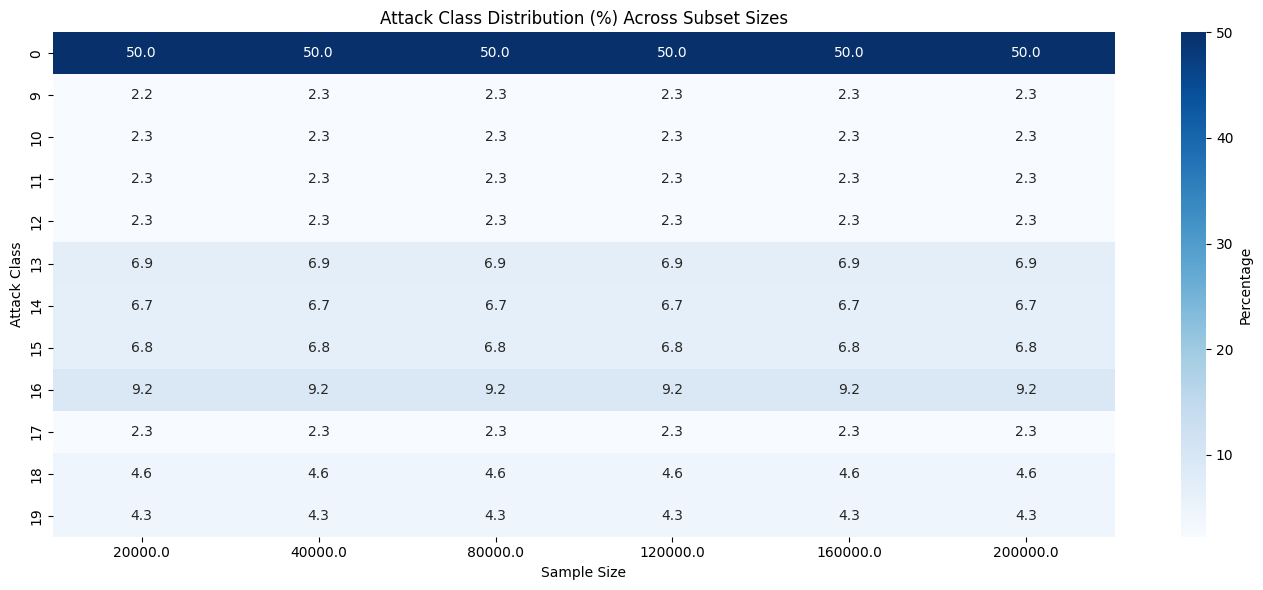

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.heatmap(subset_class_summary.T, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'Percentage'})

plt.title("Attack Class Distribution (%) Across Subset Sizes")
plt.xlabel("Sample Size")
plt.ylabel("Attack Class")
plt.tight_layout()
plt.show()


In [7]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Melt DataFrame to long format
df_long = subset_class_summary.reset_index().melt(id_vars='Sample Size', var_name='Attack Class', value_name='Percentage')
df_long['Attack Class'] = df_long['Attack Class'].astype(str)

# Generate distinct colors for each class using a colormap
unique_classes = sorted(df_long['Attack Class'].unique(), key=lambda x: int(x))
color_map = cm.get_cmap('tab20', len(unique_classes))
class_colors = {cls: mcolors.to_hex(color_map(i)) for i, cls in enumerate(unique_classes)}

# Create 3D lines for each (Sample Size, Attack Class)
fig = go.Figure()

for _, row in df_long.iterrows():
    x = row['Sample Size']
    y = row['Attack Class']
    z = row['Percentage']
    color = class_colors[y]

    fig.add_trace(go.Scatter3d(
        x=[x, x],
        y=[y, y],
        z=[0, z],
        mode='lines',
        line=dict(color=color, width=10),
        name=f'Class {y}',
        showlegend=False,
        hovertemplate=f"Sample Size: {x}<br>Attack Class: {y}<br>Percentage: {z:.2f}%<extra></extra>"
    ))

# Add legend entries manually (one per class)
for cls, color in class_colors.items():
    fig.add_trace(go.Scatter3d(
        x=[None], y=[None], z=[None],
        mode='lines',
        line=dict(color=color, width=10),
        name=f'Class {cls}',
        showlegend=True
    ))

# Layout
fig.update_layout(
    title="3D Class-Wise Distribution Across Sample Sizes",
    scene=dict(
        xaxis_title='Sample Size',
        yaxis_title='Attack Class',
        zaxis_title='Percentage',
    ),
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()


<ipython-input-7-981602176>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', len(unique_classes))


## LSTM TESTING 20000

In [8]:
import pandas as pd

df = pd.read_csv('/content/veremi_stratified_20000.csv')
df.info()
df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type          20000 non-null  int64  
 1   sendTime      20000 non-null  float64
 2   sender        20000 non-null  int64  
 3   senderPseudo  20000 non-null  int64  
 4   messageID     20000 non-null  int64  
 5   class         20000 non-null  int64  
 6   posx          20000 non-null  float64
 7   posy          20000 non-null  float64
 8   posz          20000 non-null  float64
 9   spdx          20000 non-null  float64
 10  spdy          20000 non-null  float64
 11  spdz          20000 non-null  float64
 12  aclx          20000 non-null  float64
 13  acly          20000 non-null  float64
 14  aclz          20000 non-null  float64
 15  hedx          20000 non-null  float64
 16  hedy          20000 non-null  float64
 17  hedz          20000 non-null  float64
 18  Attack        20000 non-nu

,type,sendTime,sender,senderPseudo,messageID,class,posx,posy,posz,spdx,...,spdz,aclx,acly,aclz,hedx,hedy,hedz,Attack,Attack_type,binary_label
0,4,56645.238071,81621,10816215,244255294,0,249.824980,405.237117,0.0,-6.011002,...,0.0,2.751941,2.062643,0.0,-0.804021,-0.594600,0.0,Normal,Normal behavior,0
1,4,62703.878111,94773,10947736,282677119,13,1180.833832,784.077835,0.0,-9.630062,...,0.0,0.378693,0.408204,0.0,-0.719064,-0.694944,0.0,Attack,DoS disruptive,1
2,4,48553.276086,67671,10676714,202740336,10,920.863634,628.141824,0.0,3.410431,...,0.0,-1.318903,-2.977396,0.0,0.445309,0.895377,0.0,Attack,Data replay,1
3,4,28123.107181,18975,20189752,45141196,16,916.104651,621.375901,0.0,-1.454104,...,0.0,-1.466771,-3.105949,0.0,0.471753,0.881731,0.0,Attack,DoS random sybil,1
4,4,24903.305602,9729,1097292,16869316,0,899.948212,589.091061,0.0,6.965031,...,0.0,-0.369491,-0.558042,0.0,0.671635,0.740882,0.0,Normal,Normal behavior,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,4,67645.466708,113763,101137636,358613707,0,273.868611,423.324800,0.0,-9.250936,...,0.0,2.193360,1.751994,0.0,-0.909155,-0.416458,0.0,Normal,Normal behavior,0
19996,4,33963.614750,39897,10398973,125038911,0,161.859199,718.821045,0.0,-1.960121,...,0.0,-0.009112,0.061856,0.0,-0.044394,0.999014,0.0,Normal,Normal behavior,0
19997,4,65171.490107,104073,101040736,319716230,14,657.564877,779.357255,0.0,13.719221,...,0.0,0.847514,1.799761,0.0,-0.670660,-0.728144,0.0,Attack,Data replay sybil,1
19998,4,29324.745671,23535,20235352,61461778,16,1390.291153,1148.072546,0.0,0.301333,...,0.0,0.291288,0.821085,0.0,-0.375159,-0.926960,0.0,Attack,DoS random sybil,1


preprocessing pipeline

* Loads the CSV
* Drops irrelevant columns
* Normalizes with StandardScaler
* Reshapes for LSTM
* Splits into train/test sets
* Returns all ready-to-train arrays

In [9]:
# STEP 1: Install TensorFlow (only once)
!pip install tensorflow


In [10]:
# STEP 2: Imports
import pandas as pd
import numpy as np
import time
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense


In [11]:
# STEP 3: Load or Initialize Results DataFrame
try:
    results_df = pd.read_csv("/content/lstmgruatt_test_results.csv")
    print("Loaded previous results")
except FileNotFoundError:
    results_df = pd.DataFrame(columns=[
        'Timestamp', 'Model', 'Dataset', 'Sample Size', 'Training Time (s)', 'Best Epoch','Accuracy', 'Precision', 'Recall', 'F1 Score',
        'Confusion Matrix', 'CPU Usage (%)', 'Memory Usage (MB)', 'Model Size (MB)', 'Inference Time (s)'
    ])
    print("Created new results table")

Created new results table


* 90:5:5 train/val/test split
* Validation accuracy tracking
* Early stopping to prevent overfitting
* Train/validation loss/accuracy plots

In [12]:
def prepare_dataset(file_path, random_state=42):
  # Single time step
    df = pd.read_csv(file_path)
    drop_cols = ['Attack', 'Attack_type', 'class', 'binary_label', 'messageID', 'sender', 'senderPseudo']
    X = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    if 'binary_label' not in df.columns:
        raise ValueError("binary_label column missing in dataset.")

    y = df['binary_label'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.10, stratify=y, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state)

    # For LSTM/GRU: (samples, timesteps=1, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train, X_val, X_test, y_train, y_val, y_test, X_train.shape[2]


In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Concatenate, Attention, GlobalAveragePooling1D

def create_lstm_gru_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM branch
    lstm_out = LSTM(64, return_sequences=True)(inputs)

    # GRU branch
    gru_out = GRU(64, return_sequences=True)(inputs)

    # Combine both branches
    combined = Concatenate(axis=-1)([lstm_out, gru_out])

    # Attention mechanism
    attn_out = Attention()([combined, combined])  # Self-attention returns (batch, time, features)

    # Flatten the sequence: collapse time dimension
    x = GlobalAveragePooling1D()(attn_out)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, x)
    return model


In [14]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt
import psutil
import time
import numpy as np
import os

def train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, dataset_name, sample_size, results_df):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    model_path = f'{sample_size}_{xModel}_mcp_{timestamp}.keras'
    if xModel == "LSTMGRU_ATT":
        model = create_lstm_gru_attention_model((X_train.shape[1], X_train.shape[2]))
    else:
        raise ValueError(f"Unknown model type: {xModel}")

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

    # Training
    train_start = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    training_time = time.time() - train_start

    # Load best checkpoint
    model = load_model(model_path)

    # Inference
    infer_start = time.time()
    y_pred_prob = model.predict(X_test).ravel()
    inference_time = (time.time() - infer_start) / len(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    best_epoch = np.argmin(history.history['val_loss']) + 1
    patience_used = len(history.history['val_loss']) - best_epoch

    cpu_usage = psutil.cpu_percent(interval=1)
    memory_usage = psutil.virtual_memory().used / (1024 ** 2)
    model_size = os.path.getsize(model_path) / (1024 * 1024)

    # Log results
    results_df.loc[len(results_df)] = {
        'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Model': xModel,
        'Dataset': dataset_name,
        'Sample Size': sample_size,
        'Training Time (s)': round(training_time, 2),
        'Best Epoch': best_epoch,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'Confusion Matrix': str(cm),
        'CPU Usage (%)': cpu_usage,
        'Memory Usage (MB)': round(memory_usage, 2),
        'Model Size (MB)': model_size,
        'Inference Time (s)': round(inference_time, 6)
    }

    # Plot training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axvline(x=best_epoch - 1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.axvline(x=best_epoch - 1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Early stopping triggered. Best epoch: {best_epoch}, patience used: {patience_used}")
    print(f"Best model saved to: {model_path}")

    return results_df, cm


In [15]:
import matplotlib.pyplot as plt

def save_and_visualize_results(results_df, xmarker='o', save_path="lstmgru_test_results.csv"):
    # Save to CSV
    results_df.to_csv(save_path, index=False)
    print(f"Results saved to {save_path}")

    # Plot selected metrics as markers only (no connecting lines)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    plt.figure(figsize=(10, 6))
    for metric in metrics:
        plt.scatter(results_df['Sample Size'], results_df[metric], marker=xmarker, label=metric)

    plt.xlabel("Sample Size")
    plt.ylabel("Score")
    plt.title("LSTM Classification Metrics by Sample Size")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Display last result row
    from IPython.display import display
    display(results_df.tail(1))

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels, title, filename):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)   #Save the image
    plt.show()              # Show inline
    plt.close()             # Clean up the figure



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 64)     │     20,224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 1, 64)     │     15,360 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 128)    │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 128)    │          0 │ concatenate[0][0… │
│ (Attention)         │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,953 (179.50 KB)

 Trainable params: 45,953 (179.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning:

You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?



279/282 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6213 - loss: 0.6212
Epoch 1: val_loss improved from inf to 0.56200, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_15-37-47.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.6218 - loss: 0.6208 - val_accuracy: 0.6900 - val_loss: 0.5620
Epoch 2/50
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6849 - loss: 0.5578
Epoch 2: val_loss improved from 0.56200 to 0.55537, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_15-37-47.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6849 - loss: 0.5578 - val_accuracy: 0.6880 - val_loss: 0.5554
Epoch 3/50
275/282 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6972 - loss: 0.5507
Epoch 3: val_loss improved from 0.55537 to 0.55017, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_15-37-47.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6972 - loss: 0.5507 - val_accuracy: 0.6810 - val_loss: 0.5502
Epoch 4/50
277/282 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accura

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning:

You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?



32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


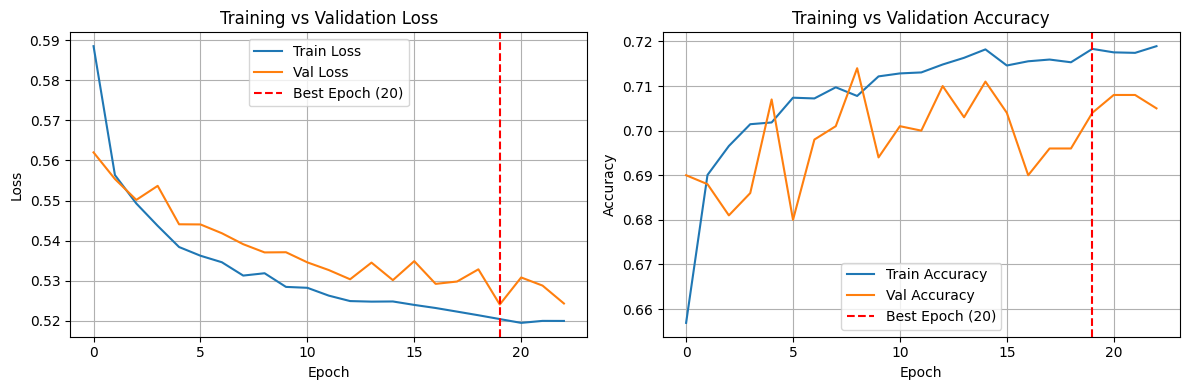

Early stopping triggered. Best epoch: 20, patience used: 3
Best model saved to: 14_LSTMGRU_ATT_mcp_2025-06-15_15-37-47.keras
Results saved to lstmgru_test_results.csv


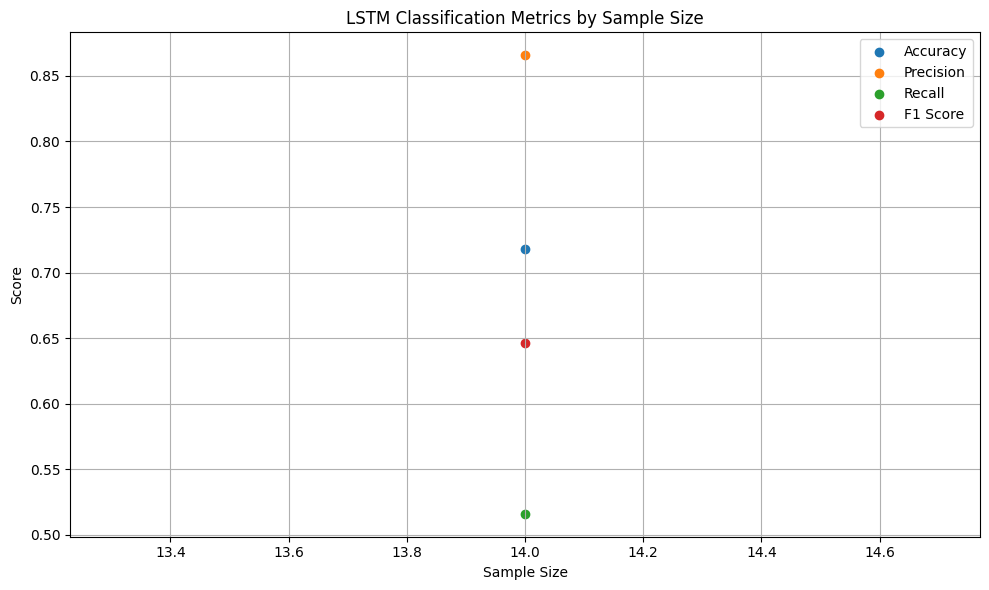

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
0,2025-06-15 15:39:27,LSTMGRU_ATT,veremi_stratified_20000.csv,14,96.82,20,0.718,0.865772,0.516,0.646617,[[460 40]\n [242 258]],3.5,1615.06,0.578823,0.00136


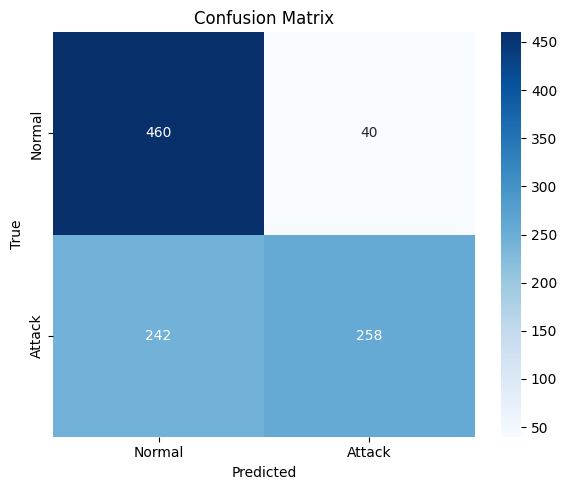

In [17]:
xModel="LSTMGRU_ATT"
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_dataset('/content/veremi_stratified_20000.csv')
results_df, cm = train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_20000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'o')
plot_confusion_matrix(cm, labels=["Normal", "Attack"], title="Confusion Matrix", filename=f"{xModel}_{sample_size}_cm.png")


In [ ]:
xModel="LSTMGRU_ATT"
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_dataset('/content/veremi_stratified_40000.csv')
results_df, cm = train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_40000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'x')
plot_confusion_matrix(cm, labels=["Normal", "Attack"], title="Confusion Matrix", filename=f"{xModel}_{sample_size}_cm.png")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 1, 64)     │     20,224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 1, 64)     │     15,360 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1, 128)    │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 1, 128)    │          0 │ concatenate_1[0]… │
│ (Attention)         │                   │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_1[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,953 (179.50 KB)

 Trainable params: 45,953 (179.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning:

You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?



559/563 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6416 - loss: 0.5991
Epoch 1: val_loss improved from inf to 0.54697, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_15-39-28.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6419 - loss: 0.5988 - val_accuracy: 0.6975 - val_loss: 0.5470
Epoch 2/50
559/563 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6964 - loss: 0.5475
Epoch 2: val_loss improved from 0.54697 to 0.54108, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_15-39-28.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6964 - loss: 0.5475 - val_accuracy: 0.6955 - val_loss: 0.5411
Epoch 3/50
556/563 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7007 - loss: 0.5445
Epoch 3: val_loss improved from 0.54108 to 0.53859, saving model to 14_LSTMGRU_ATT_mcp_2025-06-15_15-39-28.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7007 - loss: 0.5445 - val_accuracy: 0.6995 - val_loss: 0.5386
Epoch 4/50
558/563 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 

In [ ]:
xModel="LSTMGRU_ATT"
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_dataset('/content/veremi_stratified_80000.csv')
results_df, cm = train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_80000.csv', sample_size, results_df)
save_and_visualize_results(results_df, '+')
plot_confusion_matrix(cm, labels=["Normal", "Attack"], title="Confusion Matrix", filename=f"{xModel}_{sample_size}_cm.png")

In [ ]:
xModel="LSTMGRU_ATT"
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_dataset('/content/veremi_stratified_120000.csv')
results_df, cm = train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_120000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 'v')
plot_confusion_matrix(cm, labels=["Normal", "Attack"], title="Confusion Matrix", filename=f"{xModel}_{sample_size}_cm.png")

In [ ]:
xModel="LSTMGRU_ATT"
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_dataset('/content/veremi_stratified_160000.csv')
results_df, cm = train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_160000.csv', sample_size, results_df)
save_and_visualize_results(results_df, '^')
plot_confusion_matrix(cm, labels=["Normal", "Attack"], title="Confusion Matrix", filename=f"{xModel}_{sample_size}_cm.png")

In [ ]:
xModel="LSTMGRU_ATT"
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_dataset('/content/veremi_stratified_200000.csv')
results_df, cm = train_and_evaluate_model(xModel, X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_200000.csv', sample_size, results_df)
save_and_visualize_results(results_df, 's')
plot_confusion_matrix(cm, labels=["Normal", "Attack"], title="Confusion Matrix", filename=f"{xModel}_{sample_size}_cm.png")

In [ ]:
from google.colab import files
files.download("/content/lstmgru_test_results.csv")

In [ ]:
from datetime import datetime

# Get current date and time
now = datetime.now()

# Print formatted datetime
print("Current date and time:", now.strftime("%Y-%m-%d %H:%M:%S"))